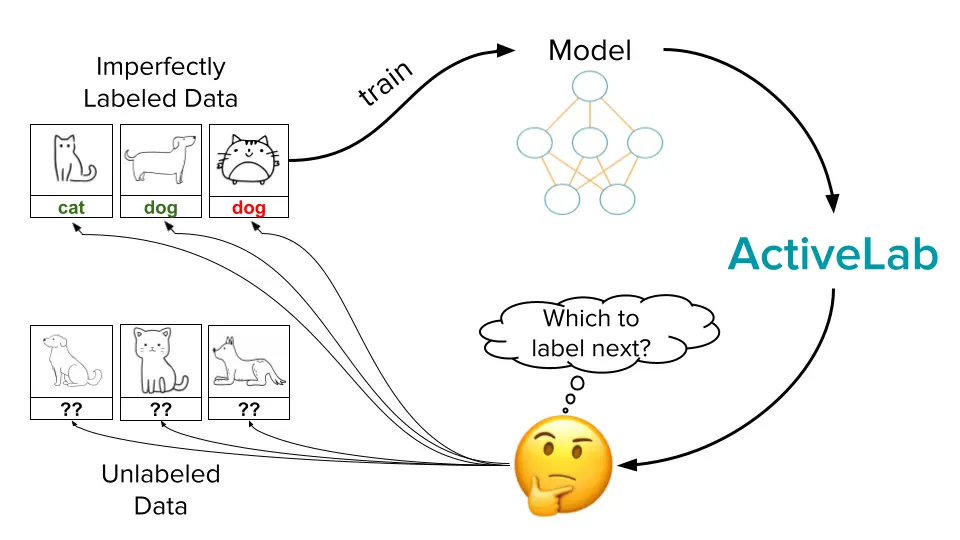

In [ ]:
!pip install datasets transformers scikit-learn matplotlib cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.8/349.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.set_option('max_colwidth', None)
import numpy as np
import random
import transformers
import datasets
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_majority_vote_label, get_active_learning_scores, get_label_quality_multiannotator
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.special import softmax
from datetime import datetime

## Collecting and Organizing Data

Here we download the data that we need for this notebook.

In [ ]:
labeled_data_file = {"labeled": "X_labeled_full.csv"}
unlabeled_data_file = {"unlabeled": "X_labeled_full.csv"}
test_data_file = {"test": "test.csv"}

X_labeled_full = load_dataset("Cleanlab/stanford-politeness", split="labeled", data_files=labeled_data_file)
X_unlabeled = load_dataset("Cleanlab/stanford-politeness", split="unlabeled", data_files=unlabeled_data_file)
test = load_dataset("Cleanlab/stanford-politeness", split="test", data_files=test_data_file)

!wget -nc -O 'extra_annotations.npy' 'https://huggingface.co/datasets/Cleanlab/stanford-politeness/resolve/main/extra_annotations.npy?download=true'

extra_annotations = np.load("extra_annotations.npy",allow_pickle=True).item()

README.md:   0%|          | 0.00/852 [00:00<?, ?B/s]

X_labeled_full.csv:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

Generating labeled split: 0 examples [00:00, ? examples/s]

Generating unlabeled split: 0 examples [00:00, ? examples/s]

test.csv:   0%|          | 0.00/256k [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

--2025-03-11 09:09:45--  https://huggingface.co/datasets/Cleanlab/stanford-politeness/resolve/main/extra_annotations.npy?download=true
Resolving huggingface.co (huggingface.co)... 3.165.160.11, 3.165.160.61, 3.165.160.59, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.11|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/3a/2f/3a2fc34cf625e69cabda6493d475e2b30302e6ccd28e9f3d398c1055528f129d/d89f555ae53ec9849439fd00fe71803462cf153175b29986958e47c0b4f8fd51?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27extra_annotations.npy%3B+filename%3D%22extra_annotations.npy%22%3B&Expires=1741687785&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTY4Nzc4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzNhLzJmLzNhMmZjMzRjZjYyNWU2OWNhYmRhNjQ5M2Q0NzVlMmIzMDMwMmU2Y2NkMjhlOWYzZDM5OGMxMDU1NTI4ZjEyOWQvZDg5ZjU1NWFlNTNlYzk4NDk0MzlmZDAwZmU3MTgwMzQ2MmNmMTUzMTc1

In [ ]:
X_labeled_full = X_labeled_full.to_pandas()
X_labeled_full.set_index('id', inplace=True)
X_unlabeled = X_unlabeled.to_pandas()
X_unlabeled.set_index('id', inplace=True)
test = test.to_pandas()

## Classifying the Politeness of Text

We are using [Stanford Politeness Corpus](https://convokit.cornell.edu/documentation/wiki_politeness.html) as the Dataset.

It is structured as a binary text classification task, to classify whether each phrase is polite or impolite. Human annotators are given a selected text phrase and they provide an (imperfect) annotation regarding its politeness: **0** for impolite and **1** for polite.

Training a Transformer classifier on the annotated data, we measure model accuracy over a set of held-out test examples, where I feel confident about their ground truth labels because they are derived from a consensus amongst 5 annotators who labeled each of these examples.

As for the training data, we have:

- `X_labeled_full`: our initial training set with just a small set of 100 text examples labeled with 2 annotations per example.
- `X_unlabeled`: large set of 1900 unlabeled text examples we can consider having annotators label.
- `extra_annotations`: pool of additional annotations we pull from when an annotation is requested for an example

## Visualize Data

In [ ]:
# Multi-annotated Data
X_labeled_full.head()

,text,a6,a12,a16,a19,a20,a22,a39,a42,a52,...,a157,a158,a178,a180,a185,a193,a196,a197,a215,a216
id,,,,,,,,,,,,,,,,,,,,,
450d326d,"<url>. Congrats, or should I say good luck?",NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6a22f4ec,Can I get some time to finish what I am doing without everything being deleted??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823f1104,"Ok. Thank you for clarifying. Could you be more specific as to what you are specifying as ""the claim"" so that I may find relevant information to refute?",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7677905a,"One wonders, of course, who ""Elliott of Macedon"" would have been. Probably something analogous to Brian of Nazareth but in a Macedonian phalanx?",NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
a1ce799b,"So, let me make sure I understand this. You think that, if we remove an image as it does not meet the NFCC, you would then be able to upload the same image, only this time, it would meet the NFCC?",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0


In [ ]:
# Unlabeled Data
X_unlabeled.head()

,text,a6,a12,a16,a19,a20,a22,a39,a42,a52,...,a157,a158,a178,a180,a185,a193,a196,a197,a215,a216
id,,,,,,,,,,,,,,,,,,,,,
450d326d,"<url>. Congrats, or should I say good luck?",NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6a22f4ec,Can I get some time to finish what I am doing without everything being deleted??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823f1104,"Ok. Thank you for clarifying. Could you be more specific as to what you are specifying as ""the claim"" so that I may find relevant information to refute?",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7677905a,"One wonders, of course, who ""Elliott of Macedon"" would have been. Probably something analogous to Brian of Nazareth but in a Macedonian phalanx?",NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
a1ce799b,"So, let me make sure I understand this. You think that, if we remove an image as it does not meet the NFCC, you would then be able to upload the same image, only this time, it would meet the NFCC?",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0


In [ ]:
# extra_annotations contains the annotations that we will use when an additional annotation is requested.
extra_annotations

# Random sample of extra_annotations to see format.
{k: extra_annotations[k] for k in random.sample(list(extra_annotations.keys()), 5)}
# Convert the dict_keys object to a list using list() before passing it to random.sample.

{'fe7a06c6': {'a61': 0.0, 'a70': 0.0, 'a99': 1.0, 'a157': 0.0, 'a195': 0.0},
 'd4a75763': {'a58': 0.0, 'a61': 0.0, 'a93': 0.0, 'a120': 0.0, 'a216': 0.0},
 '6f9a18d2': {'a45': 0.0, 'a61': 0.0, 'a99': 0.0, 'a157': 0.0, 'a208': 0.0},
 '3c47e9f9': {'a61': 1.0, 'a68': 1.0, 'a176': 0.0, 'a185': 1.0, 'a198': 1.0},
 'ae09acab': {'a68': 1.0, 'a70': 1.0, 'a76': 1.0, 'a157': 1.0, 'a195': 1.0}}

# View Some Examples From Test Set

In [ ]:
num_to_label = {0:'Impolite', 1:"Polite"}
for i in range(2):
    print(f"{num_to_label[i]} examples:")
    subset=test[test.label==i][['text']].sample(n=3, random_state=2)
    print(subset)

Impolite examples:
                                                                                                                                                                                                           text
120                                                                        And wasting our time as well. I can only repeat: why don't you do constructive work by adding contents about your beloved Makedonia?
150  Rather than tell me how wrong I was to close certain afd's maybe your time would be better spent dealing with the current afd backlog <url>. If my decisions were so wrong why haven't you re-opened them?
326                                                                                                                             This was supposed to have been moved to <url> per the CFD. Why wasn't it moved?
Polite examples:
                                                                                                                            text
498

Impolite Examples:

|     |                                                                                                    text                                                                                                    |
|----:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| 120 |                                                                       And wasting our time as well. I can only repeat: why don't you do constructive work by adding contents about your beloved Makedonia? |
| 150 | Rather than tell me how wrong I was to close certain afd's maybe your time would be better spent dealing with the current afd backlog <url>. If my decisions were so wrong why haven't you re-opened them? |
| 326 |                                                                                                                            This was supposed to have been moved to <url> per the CFD. Why wasn't it moved? |

Polite Examples:

|     |                                                            text                                                            |
|----:|:--------------------------------------------------------------------------------------------------------------------------:|
| 498 |                    Hi there, I've raised the possibility of unprotecting the tamazepam page <url>. What are your thoughts? |
| 132 |                                                Due to certain Edits the page alignment has changed. Could you please help? |
| 131 | I'm glad you're pleased with the general appearance. Before I label all the streets, is the text size, font style, etc OK? |

# Helper Methods
The following section contains all of the helper methods needed for this notebook.

`get_idx_to_label` is designed for use in active learning scenarios, particularly when dealing with a mixture of labeled and unlabeled data. Its primary goal is to determine which examples (from both labeled and unlabeled datasets) should be selected for additional annotations based on their active learning scores.

In [ ]:
# Helper method to get indices of examples with the lowest active learning score to collect more labels for.
def get_idx_to_label(
    X_labeled_full,
    X_unlabeled,
    extra_annotations,
    batch_size_to_label,
    active_learning_scores,
    active_learning_scores_unlabeled=None,
):
    if active_learning_scores_unlabeled is None:
        active_learning_scores_unlabeled = np.array([])

    to_label_idx = []
    to_label_idx_unlabeled = []

    num_labeled = len(active_learning_scores)
    active_learning_scores_combined = np.concatenate((active_learning_scores, active_learning_scores_unlabeled))
    to_label_idx_combined = np.argsort(active_learning_scores_combined)

    # We want to collect the n=batch_size best examples to collect another annotation for.
    i = 0
    while (len(to_label_idx)+len(to_label_idx_unlabeled)) < batch_size_to_label:
        idx = to_label_idx_combined[i]
        # We know this is an already annotated example.
        if idx < num_labeled:
            text_id = X_labeled_full.iloc[idx].name
            # Make sure we have an annotation left to collect.
            if text_id in extra_annotations and extra_annotations[text_id]:
                to_label_idx.append(idx)
        # We know this is an example that is currently not annotated.
        else:
            # Subtract off offset to get back original index.
            idx -= num_labeled
            text_id = X_unlabeled.iloc[idx].name
            # Make sure we have an annotation left to collect.
            if text_id in extra_annotations and extra_annotations[text_id]:
                to_label_idx_unlabeled.append(idx)
        i+=1

    to_label_idx = np.array(to_label_idx)
    to_label_idx_unlabeled = np.array(to_label_idx_unlabeled)
    return to_label_idx, to_label_idx_unlabeled

`get_idx_to_label_random` is designed for an active learning context where the selection of data points for additional annotation is done randomly rather than based on a model's uncertainty or learning scores. This approach might be used as a baseline to compare against more sophisticated active learning strategies or in scenarios where it's unclear how to score examples.

In [ ]:
# Helper method to get indices of random examples to collect more labels for.
def get_idx_to_label_random(
    X_labeled_full,
    X_unlabeled,
    extra_annotations,
    batch_size_to_label
):
    to_label_idx = []
    to_label_idx_unlabeled = []

    # Generate list of indices for both sets of examples.
    labeled_idx = [(x, 'labeled') for x in range(len(X_labeled_full))]
    unlabeled_idx = []
    if X_unlabeled is not None:
        unlabeled_idx = [(x, 'unlabeled') for x in range(len(X_unlabeled))]
    combined_idx = labeled_idx + unlabeled_idx

    # We want to collect the n=batch_size random examples to collect another annotation for.
    while (len(to_label_idx)+len(to_label_idx_unlabeled)) < batch_size_to_label:
        # Random choice from indices.
        # We time-seed to ensure randomness.
        random.seed(datetime.now().timestamp())
        choice = random.choice(combined_idx)
        idx, which_subset = choice
        # We know this is an already annotated example.
        if which_subset == 'labeled':
            text_id = X_labeled_full.iloc[idx].name
            # Make sure we have an annotation left to collect.
            if text_id in extra_annotations and extra_annotations[text_id]:
                to_label_idx.append(idx)
            combined_idx.remove(choice)
        # We know this is an example that is currently not annotated.
        else:
            text_id = X_unlabeled.iloc[idx].name
            # Make sure we have an annotation left to collect.
            if text_id in extra_annotations and extra_annotations[text_id]:
                to_label_idx_unlabeled.append(idx)
            combined_idx.remove(choice)

    to_label_idx = np.array(to_label_idx)
    to_label_idx_unlabeled = np.array(to_label_idx_unlabeled)
    return to_label_idx, to_label_idx_unlabeled

Below are some utility methods which helps us to compute standard deviation, selecting a specific annotator who has previously annotated the example, and some token functions to Tokenize text examples.

In [ ]:
# Helper method to compute std dev across 2D array of accuracies.
def compute_std_dev(accuracy):
    def compute_std_dev_ind(accs):
        mean = np.mean(accs)
        std_dev = np.std(accs)
        return np.array([mean - std_dev, mean + std_dev])

    std_dev = np.apply_along_axis(compute_std_dev_ind, 0, accuracy)
    return std_dev

# Helper method to select which annotator we should collect another annotation from.
def choose_existing(annotators, existing_annotators):
    for annotator in annotators:
        # If we find one that has already given an annotation, we return it.
        if annotator in existing_annotators:
            return annotator
    # If we don't find an existing, just return a random one.
    choice = random.choice(list(annotators.keys()))
    return choice

# Helper method for Trainer.
def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=1)
    pred_probs = softmax(logits, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    return {"logits":logits, "pred_probs":pred_probs, "accuracy": accuracy}

# Helper method to tokenize text.
def tokenize_function(examples):
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Helper method to tokenize given dataset.
def tokenize_data(data):
    dataset = Dataset.from_dict({"label":data['label'] , "text": data['text'].values})
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.cast_column("label", ClassLabel(names = ["0","1"]))
    return tokenized_dataset

`get_trainer` function here is designed to set up a training environment for a text classification task using DistilBERT, a distilled version of the BERT model that is lighter and faster.

In [ ]:
# Helper method to initiate a new Trainer with given train and test sets.
def get_trainer(train_set, test_set):

    # Model params.
    model_name = "distilbert-base-uncased"
    model_folder = "model_training"
    max_training_steps = 300
    num_classes = 2

    # Set training args.
    # We time-seed to ensure randomness between different benchmarking runs.
    training_args = TrainingArguments(
        max_steps=max_training_steps,
        output_dir=model_folder,
        seed = int(datetime.now().timestamp())
    )

    # Tokenize train/test set.
    train_tokenized_dataset = tokenize_data(train_set)
    test_tokenized_dataset = tokenize_data(test_set)

    # Initiate a pre-trained model.
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics = compute_metrics,
        train_dataset = train_tokenized_dataset,
        eval_dataset = test_tokenized_dataset,
    )
    return trainer

`get_pred_probs` function performs out-of-sample prediction probability computation for a given dataset using cross-validation, with additional handling for unlabeled data.

In [ ]:
# Helper method to manually compute cross-validated predicted probabilities needed for ActiveLab.
def get_pred_probs(X, X_unlabeled):
    """Uses cross-validation to obtain out-of-sample predicted probabilities
    for given dataset"""

    # Generate cross-val splits.
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    skf_splits = [
        [train_index, test_index]
        for train_index, test_index in skf.split(X=X['text'], y=X['label'])
    ]

    # Initiate empty array to store pred_probs.
    num_examples, num_classes = len(X), len(X.label.value_counts())
    pred_probs = np.full((num_examples, num_classes), np.NaN)
    pred_probs_unlabeled = None

    # If we use up all examples from the initial unlabeled pool, X_unlabeled will be None.
    if X_unlabeled is not None:
        pred_probs_unlabeled = np.full((n_splits, len(X_unlabeled), num_classes), np.NaN)

    # Iterate through cross-validation folds.
    for split_num, split in enumerate(skf_splits):
        train_index, test_index = split

        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

        # Get trainer with train/test subsets.
        trainer = get_trainer(train_set, test_set)
        trainer.train()
        eval_metrics = trainer.evaluate()

        # Get pred_probs and insert into dataframe.
        pred_probs_fold = eval_metrics['eval_pred_probs']
        pred_probs[test_index] = pred_probs_fold

        # Since we don't have labels for the unlabeled pool, we compute pred_probs at each round of CV
        # and then average the results at the end.
        if X_unlabeled is not None:
            dataset_unlabeled = Dataset.from_dict({"text": X_unlabeled['text'].values})
            unlabeled_tokenized_dataset = dataset_unlabeled.map(tokenize_function, batched=True)
            logits = trainer.predict(unlabeled_tokenized_dataset).predictions
            curr_pred_probs_unlabeled = softmax(logits, axis=1)
            pred_probs_unlabeled[split_num] = curr_pred_probs_unlabeled

    # Here we average the pred_probs from each round of CV to get pred_probs for the unlabeled pool.
    if X_unlabeled is not None:
        pred_probs_unlabeled = np.mean(np.array(pred_probs_unlabeled), axis=0)

    return pred_probs, pred_probs_unlabeled

`get_annotator` function determines the most appropriate annotator to collect a new annotation from for a specific example, based on a set of criteria while `get_annotation` focused on collecting an actual annotation for a given example from a chosen annotator, it also deletes the collected annotation from the pool to prevent it from being selected again.

In [ ]:
# Helper method to determine which annotator to collect annotation from for given example.
def get_annotator(example_id):
    # Update who has already annotated atleast one example.
    existing_annotators = set(X_labeled_full.drop('text', axis=1).columns)
    # Returns the annotator we want to collect annotation from.
    # Chooses existing annotators first.
    annotators = extra_annotations[example_id]
    chosen_annotator = choose_existing(annotators, existing_annotators)
    return chosen_annotator

# Helper method to collect an annotation for given text example.
def get_annotation(example_id, chosen_annotator):

    # Collect new annotation.
    new_annotation = extra_annotations[example_id][chosen_annotator]

    # Remove annotation.
    del extra_annotations[example_id][chosen_annotator]

    return new_annotation

Run the following cell to hide the HTML output from the next model training block.

In [ ]:
%%html
<style>
    div.output_stderr {
    display: none;
    }
</style>

## Methodology Used

For each **active learning** round we:

1. Compute ActiveLab consensus labels for each training example derived from all annotations collected thus far.
2. Train our Transformer classification model on the current training set using these consensus labels.
3. Evaluate test accuracy on the test set (which has high-quality ground truth labels).
4. Run cross-validation to get out-of-sample predicted class probabilities from our model for the entire training set and unlabeled set.
5. Get ActiveLab active learning scores for each example in the training set and unlabeled set. These scores estimate how informative it would be to collect another annotation for each example.
6. Select a subset (*n = batch_size*) of examples with the lowest active learning scores.
7. Collect one additional annotation for each of the *n* selected examples.
8. Add the new annotations (and new previously non-annotated examples if selected) to our training set for the next iteration.

I subsequently compare models trained on data labeled via active learning vs. data labeled via **random selection**.  For each random selection round, I use majority vote consensus instead of ActiveLab consensus (in Step 1) and then just randomly select the **n** examples to collect an additional label for instead of using ActiveLab scores (in Step 6).

More intuition on Activelab Consensus labels and Active learning scores are shared further in the notebook.  


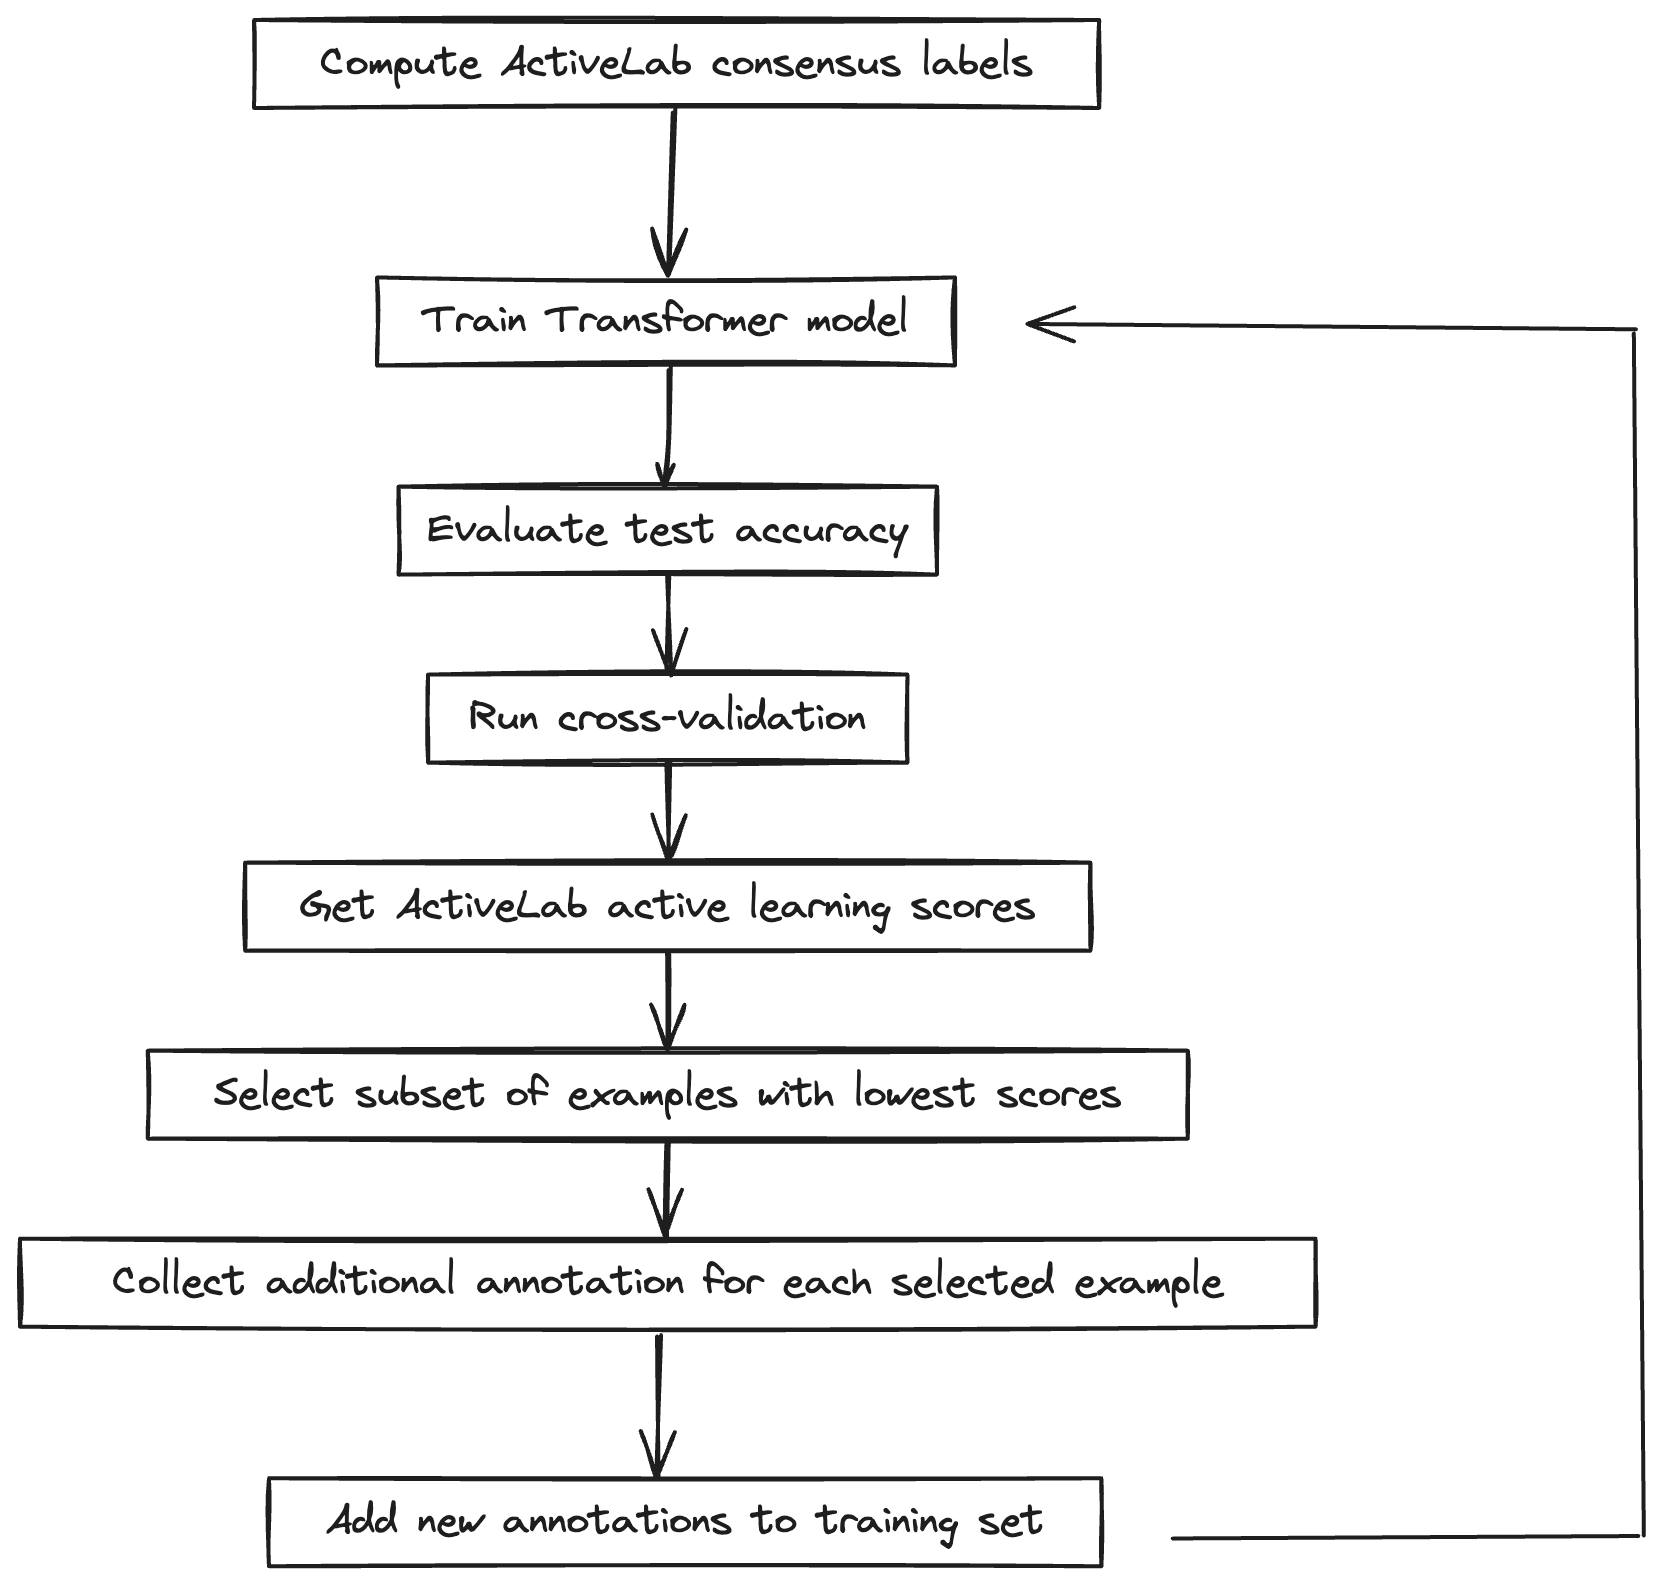

### Model Training and Evaluation

I first tokenize my test and train sets, and then initialize a pre-trained DistilBert Transformer model. Fine-tuning DistilBert with 300 training steps produced a good balance between accuracy and training time for my data. This classifier outputs predicted class probabilities which I convert to class predictions before evaluating their accuracy.

### Use Active Learning Scores to Decide what to Label Next
During each round of Active Learning, we fit our Transformer model via 3-fold cross-validation on the current training set. This allows us to get out-of-sample predicted class probabilities for each example in the training set and we can also use the trained Transformer to get out-of-sample predicted class probabilities for each example in the unlabeled pool. All of this is internally implemented in the `get_pred_probs` helper method. The use of out-of-sample predictions helps us avoid bias due to potential overfitting.

Once I have these probabilistic predictions, I pass them into the `get_active_learning_scores` method from the open-source [cleanlab](https://github.com/cleanlab/cleanlab) package, which implements the [ActiveLab algorithm](https://arxiv.org/abs/2301.11856).  This method provides us with scores for all of our labeled and unlabeled data. Lower scores indicate data points for which collecting one additional label should be most informative for our current model (scores are directly comparable between labeled and unlabeled data).

I form a batch of examples with the lowest scores as the examples to collect an annotation for (via the `get_idx_to_label` method). Here I always collect the exact same number of annotations in each round (under both the active learning and random selection approaches). For this application, I limit the maximum number of annotations per example to 5 (don’t want to spend effort labeling the same example over and over again).

### Adding new Annotations
The `combined_example_ids` are the ids of the text examples we want to collect an annotation for. For each of these, we use the `get_annotation` helper method to collect a new annotation from an annotator. Here, we prioritize selecting annotations from annotators who have already annotated another example. If none of the annotators for the given example exist in the training set, we randomly select one. In this case, we add a new column to our training set which represents the new annotator. Finally, we add the newly collected annotation to the training set. If the corresponding example was previously non-annotated, we also add it to the training set and remove it from the unlabeled collection.

We’ve now completed one round of collecting new annotations and retrain the Transformer model on the updated training set.  We repeat this process in multiple rounds to keep growing the training dataset and improving our model.

## Results

After running 25 rounds of active learning (labeling batches of data and retraining the Transformer model), collecting 25 annotations in each round. I repeated all of this, the next time using random selection to choose which examples to annotate in each round — as a baseline comparison. Before additional data are annotated, both approaches start with the same initial training set of 100 examples (hence achieving roughly the same Transformer accuracy in the first round).  Because of inherent stochasticity in training Transformers, I ran this entire process five times (for each data labeling strategy) and report the standard deviation (shaded region) and mean (solid line) of test accuracies across the five replicate runs.

In [ ]:
# Get numpy array of results.
!wget -nc -O 'random_acc.npy' 'https://huggingface.co/datasets/Cleanlab/stanford-politeness/resolve/main/activelearn_acc.npy'
!wget -nc -O 'activelearn_acc.npy' 'https://huggingface.co/datasets/Cleanlab/stanford-politeness/resolve/main/random_acc.npy'

--2025-03-11 09:39:48--  https://huggingface.co/datasets/Cleanlab/stanford-politeness/resolve/main/activelearn_acc.npy
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/3a/2f/3a2fc34cf625e69cabda6493d475e2b30302e6ccd28e9f3d398c1055528f129d/4cea514c5f67fd9fbe3e4257d6b63c3c724bcbbc360187ac0053afc7fb6ab9a1?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27activelearn_acc.npy%3B+filename%3D%22activelearn_acc.npy%22%3B&Expires=1741689588&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTY4OTU4OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzNhLzJmLzNhMmZjMzRjZjYyNWU2OWNhYmRhNjQ5M2Q0NzVlMmIzMDMwMmU2Y2NkMjhlOWYzZDM5OGMxMDU1NTI4ZjEyOWQvNGNlYTUxNGM1ZjY3ZmQ5ZmJlM2U0MjU3ZDZiNjNjM2M3MjRiY2JiYzM2MDE4N2FjMDA1M2FmYzdmYjZh

In [ ]:
# Helper method to compute std dev across 2D array of accuracies.
def compute_std_dev(accuracy):
    def compute_std_dev_ind(accs):
        mean = np.mean(accs)
        std_dev = np.std(accs)
        return np.array([mean - std_dev, mean + std_dev])

    std_dev = np.apply_along_axis(compute_std_dev_ind, 0, accuracy)
    return std_dev


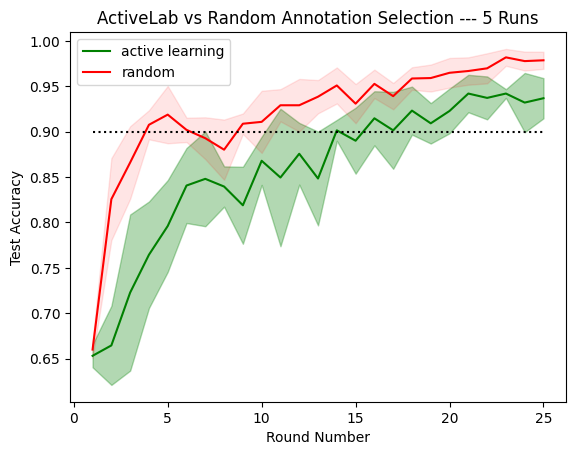

In [ ]:
al_acc = np.load('activelearn_acc.npy')
rand_acc = np.load('random_acc.npy')

rand_acc_std = compute_std_dev(rand_acc)
al_acc_std = compute_std_dev(al_acc)

plt.plot(range(1, al_acc.shape[1]+1), np.mean(al_acc, axis=0), label="active learning", color='green')
plt.fill_between(range(1, al_acc.shape[1]+1), al_acc_std[0], al_acc_std[1], alpha=0.3, color='green')

plt.plot(range(1, rand_acc.shape[1]+1), np.mean(rand_acc, axis=0), label="random", color='red')
plt.fill_between(range(1, rand_acc.shape[1]+1), rand_acc_std[0], rand_acc_std[1], alpha=0.1, color='red')

plt.hlines(y=0.9, xmin=1.0, xmax=25.0, color='black', linestyle='dotted')
plt.legend()
plt.xlabel("Round Number")
plt.ylabel("Test Accuracy")
plt.title("ActiveLab vs Random Annotation Selection --- 5 Runs")
plt.savefig("al-results.png")
plt.show()

We see that choosing what data to annotate next has drastic effects on model performance. Active learning using ActiveLab consistently outperforms random selection by a significant margin at each round. For example, in round 4 with 275 total annotations in the training set, we obtain 91% accuracy via active learning vs. only 76% accuracy without a clever selection strategy of what to annotate. Overall, the resulting Transformer models fit on the dataset constructed via active learning have around **50%** of the error-rate, no matter the total labeling budget!

**When labeling data for text classification, you should consider active learning with the re-labeling option to better account for imperfect annotators.**